<a href="https://colab.research.google.com/github/Ads369/Ads_2s/blob/main/22_2_%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D1%80%D0%B5%D0%B7%D1%8E%D0%BC%D0%B5_%D0%BA%D0%B0%D0%BD%D0%B4%D0%B8%D0%B4%D0%B0%D1%82%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Навигация по уроку**

1. [Решение задач регрессии с помощью НС](https://colab.research.google.com/drive/1GbXbqPbC4A2NVJEj-5pOOySN3gyalBQN)
2. Анализ резюме кандидатов
3. [Домашняя работа](https://colab.research.google.com/drive/1iPTkGZ_AEUpl5l6DR__J021gHR61RRfQ)

В данном практическом Блокноте мы обучим НС на наборе данных [Резюме из ЕЦП «Работа в России»](https://opendata.trudvsem.ru/csv/cv.csv) предсказывать ожидаемую зарплату соискателя по его резюме. Датасет можно получить по [ссылке](https://opendata.trudvsem.ru/csv/cv.csv) из официального источника. Однако, он периодически обновляется, имеет размер более 20Гб и может содержать ошибки, что усложняет его загрузку и обработку. Для обучающего примера, он слишком велик. Поэтому предлагается использовать его обрезанную до 100 тыс резюме [копию](https://storage.yandexcloud.net/academy.ai/cv_100000.csv) не превышающую 230Мб с исправленными ошибками.

Как всегда мы начинаем работу с импорта необходимых библиотек.

## Импорт библиотек

In [ ]:
# Для работы с массивами данных
import numpy as np

# Для работы с табличными данными
import pandas as pd

# Библиотека утилит
from keras import utils

# Для работы с моделями
from keras.models import Sequential, Model

# Слои
from keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор
from tensorflow.keras.preprocessing.text import Tokenizer

# Нормализация данных
from sklearn.preprocessing import StandardScaler

# Регулярные выражения
import re

# Для работы с графиками
import matplotlib.pyplot as plt

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Для преобразования строки в json формат
import json

%matplotlib inline

## Загрузка данных

Далее мы загружаем облегченную версию датасета. Порядок и набор полей сохранен как в оригинальном датасете.

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/cv_100000.csv

--2024-03-20 11:52:15--  https://storage.yandexcloud.net/academy.ai/cv_100000.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 237228370 (226M) [text/csv]
Saving to: ‘cv_100000.csv.1’

cv_100000.csv.1     100%[===================>] 226.24M  10.8MB/s    in 23s     

2024-03-20 11:52:40 (9.70 MB/s) - ‘cv_100000.csv.1’ saved [237228370/237228370]



In [ ]:
# Чтение файла базы данных
df = pd.read_csv('cv_100000.csv', delimiter='|', on_bad_lines='skip', low_memory=False, index_col=0)

# Вывод количества резюме и числа признаков
print('Форма данных: ', df.shape)


Форма данных:  (100000, 40)


In [ ]:
# Вывод первых 10 значений датасета
df.head(10)

,id,candidateId,stateRegionCode,locality,localityName,birthday,gender,age,positionName,dateCreate,...,softSkills,workExperienceList,scheduleType,salary,busyType,retrainingCapability,businessTrip,languageKnowledge,relocation,innerInfo
0,06a51a80-e0c7-11ec-a466-839f0d9a4379,430cbd70-b770-11ea-a28e-79a78a7da306,2.700000e+12,2.700000e+12,Хабаровский-край,1970-04-20T00:00:00+0300,Женский,53.0,Повар,2022-05-31T12:49:55+0300,...,[],[],Полный-рабочий-день,15000.0,Полная-занятость,Не-готов-к-переобучению,Не-готов-к-командировкам,[],Не-готов-к-переезду,"{""idUser"": ""aa5b6fa0-1426-11e5-8a60-1ff7059456..."
1,06a507f0-172d-11ee-aa0e-336eacb7e7a3,514b3560-172b-11ee-b7c8-2fa181561f9c,7.400000e+12,7.404200e+12,"Челябинская-область,-Чебаркульский-район,-Малк...",2006-08-03T16:00:00+0400,Мужской,17.0,Рабочий,2023-06-30T13:01:04+0300,...,[],[],Неполный-рабочий-день,18000.0,NaN,Не-готов-к-переобучению,Не-готов-к-командировкам,[],Не-готов-к-переезду,"{""idUser"": ""312ee5b0-1fef-11e5-8442-1ff7059456..."
2,06a50500-3b29-11ee-ad55-336eacb7e7a3,7ef22ae0-3b26-11ee-b4e7-df76e8ab7d11,3.000000e+12,3.001000e+12,"Астраханская-область,-Приволжский-район,-Фунто...",2005-05-11T16:00:00+0400,Мужской,18.0,Помощник-системного-администратора,2023-08-15T08:03:08+0300,...,[],[],Полный-рабочий-день,20000.0,NaN,Не-готов-к-переобучению,Готов-к-командировкам,"[{""codeLanguage"": ""Русский"", ""level"": ""Базовый...",Не-готов-к-переезду,"{""idUser"": ""f3b58240-dda3-11ed-8edf-1f7ebff536..."
3,06a4f560-7f1b-11ea-92f6-bfd13399602c,6b920b10-7f17-11ea-92f6-bfd13399602c,7.800000e+12,7.800000e+12,г-Санкт-Петербург,1987-08-17T16:00:00+0400,Женский,36.0,Специалист-по-маркетингу,2020-04-15T16:14:24+0300,...,[],"[{""companyName"": ""ФГУП \""Гос. НИИ ОЧБ\"" ФМБА Р...",Полный-рабочий-день,70000.0,Полная-занятость,Не-готов-к-переобучению,Готов-к-командировкам,"[{""codeLanguage"": ""Английский"", ""level"": ""Своб...",Не-готов-к-переезду,"{""idUser"": ""ef454300-7c5c-11e9-add8-5d9e90ab95..."
4,06a4f310-5ebf-11eb-9dd3-b905beff6f7a,20a02cd0-3b51-11eb-83b1-25bddbcbae91,2.700000e+12,2.700000e+12,Хабаровский-край,1977-12-20T15:00:00+0300,Мужской,46.0,"подручный-сталевара-,разнорабочий-,-подсобный-...",2021-01-25T06:40:10+0300,...,[],"[{""achievements"": ""<p>повышение разрядов , пов...",Полный-рабочий-день,30000.0,Полная-занятость,Готов-к-переобучению,Готов-к-командировкам,"[{""codeLanguage"": ""Русский"", ""level"": ""Родной""...",Не-готов-к-переезду,"{""idUser"": ""bc610280-8f3e-11ea-abb6-c3d833d640..."
5,06a4eda0-b219-11ea-bc60-03fd6b4dc11f,08248690-b20a-11ea-b5eb-3bfa22f2d66b,7.600000e+12,7.600000e+12,Ярославская-область,1968-04-06T00:00:00+0300,Мужской,55.0,Оперативный-дежурный,2020-06-19T13:38:34+0300,...,[],"[{""companyName"": ""ООО оп оса"", ""dateFrom"": ""20...","Сменный-график,Полный-рабочий-день",20000.0,Полная-занятость,Не-готов-к-переобучению,Не-готов-к-командировкам,[],Не-готов-к-переезду,"{""idUser"": ""35b59df0-1ffd-11e5-8442-1ff7059456..."
6,06a4eba0-56cd-11ee-9cf2-01e20877b34e,a6b061e0-5625-11ee-a3d8-df76e8ab7d11,7.400000e+12,7.400001e+12,"Челябинская-область,-г-Миасс",1975-11-24T15:00:00+0300,Женский,48.0,оператор-пк,2023-09-19T12:15:07+0300,...,[],"[{""achievements"": ""<p>Компьютерные курсы,владе...",Полный-рабочий-день,30000.0,NaN,Готов-к-переобучению,Не-готов-к-командировкам,[],Не-готов-к-переезду,"{""idUser"": ""9f224950-1fee-11e5-8442-1ff7059456..."
7,06a4df80-2325-11e7-a962-037acc02728d,4ebdd690-231c-11e7-a962-037acc02728d,5.500000e+12,5.500000e+12,Омская-область,1981-09-30T00:00:00+0400,Мужской,42.0,Электромонтёр-по-обслуживанию-и-ремонту-воздуш...,2017-04-17T07:19:19+0300,...,[],"[{""achievements"": ""<p>Повысил разряд от 2 до 4...",Вахтовый-метод,50000.0,Полная-занятость,Готов-к-переобучению,Готов-к-командировкам,"[{""codeLanguage"": ""Английский"", ""level"": ""Чтен...",Не-готов-к-переезду,"{""idUser"": ""235fd4b0-1ef2-11e5-8442-1ff7059456..."
8,06a4d0a0-4bc1-11ee-b6ed-01e20877b34e,51cde9b0-4bbf-11ee-b05a-4981f9eef779,6.300000e+12,6.300001e+12,"Самарская-о

Удалим ненужные столбцы, чтобы не перегружать оперативную память при работе с данными:

In [ ]:
df.drop(['id', 'candidateId', 'stateRegionCode', 'locality', 'birthday', 'gender', 'dateCreate', 'dateModify',
         'publishedDate', 'academicDegree', 'worldskills', 'worldskillsInspectionStatus', 'abilympicsInspectionStatus',
         'abilympicsParticipation', 'volunteersInspectionStatus', 'volunteersParticipation', 'driveLicenses', 'professionsList',
         'otherCertificates', 'narkCertificate', 'narkInspectionStatus', 'codeExternalSystem', 'country', 'additionalEducationList',
         'hardSkills', 'softSkills', 'retrainingCapability', 'businessTrip', 'languageKnowledge', 'relocation', 'innerInfo'

         ], inplace=True, axis=1)

## Обработка данных

Выведем произвольный пример и внимательно посмотрим на данные:

In [ ]:
# Пример данных

n = 3                                     # Индекс в таблице резюме
for i in range(len(df.values[n])):        # Вывод значения каждого столбца
    print('{:>2} {:>30}  {}'.format(i, df.columns[i], df.values[n][i]))

 0                   localityName  г-Санкт-Петербург
 1                            age  36.0
 2                   positionName  Специалист-по-маркетингу
 3                     experience  2
 4                  educationList  [{"faculty": "Экономический", "graduateYear": 2010, "instituteName": "«Санкт-Петербургский государственный университет аэрокосмического приборостроения»", "qualification": "Специалист по рекламе", "type": "Education"}]
 5             workExperienceList  [{"companyName": "ФГУП \"Гос. НИИ ОЧБ\" ФМБА России", "dateFrom": "2018-02-01T00:00:00+0300", "dateTo": "2019-10-01T00:00:00+0300", "demands": "<p>- Аналитика, подготовка маркетинговых исследований, отчетов;- Ведение проектов по контактному производству (также и стратегическое принятие решений во главе рабочей группы);- Мониторинг активности конкурентов;- Разработка и реализация выхода продукта на рынок;- Ценообразование;- Выработка стратегии по PR и событийному маркетингу;- Организация и участие в конференциях, фор

Для наглядности представим в виде таблицы доступное на [портале](https://trudvsem.ru/opendata/datasets) описание полей атрибутов данного датасета в формате json.

<table>
<tr><th>Код</th><th>Имя</th><th>Тип</th><th>Пример</th></tr>
<tr><td>id</td><td>Идентификатор резюме на Портале</td><td>timeuuid</td><td>08b23f30-3eb7-11ed-be3b-f5407cdefa62</td></tr>
<tr><td>stateRegionCode</td><td>Код федерального региона</td><td>varchar</td><td>9900000000000</td></tr>
<tr><td>locality</td><td>Код населенного пункта</td><td>varchar</td><td>4000000100000</td></tr>
<tr><td>localityName</td><td>Наименование населенного пункта</td><td>varchar</td><td>Калужская область, г. Калуга</td></tr>
<tr><td>birthday</td><td>Дата рождения</td><td>date</td><td>2018-11-30</td></tr>
<tr><td>age</td><td>Возраст</td><td>int</td><td>25</td></tr>
<tr><td>gender</td><td>Пол</td><td>varchar</td><td>Мужской</td></tr>
<tr><td>positionName</td><td>Наименование резюме</td><td>varchar</td><td>Воспитатель</td></tr>
<tr><td>dateCreate</td><td>Дата создания</td><td>date</td><td>2022-12-01T14:54:42+0000</td></tr>
<tr><td>dateModify</td><td>Дата изменения</td><td>date</td><td>2022-12-01T14:54:42+0000</td></tr>
<tr><td>publishedDate</td><td>Дата публикации</td><td>date</td><td>2022-12-01T14:54:42+0000</td></tr>
<tr><td>academicDegree</td><td>Ученая степень</td><td>varchar</td><td>Кандидат наук</td></tr>
<tr><td>worldskills</td><td>Информация о компетенции Worldskills</td><td> - </td><td> - </td></tr>
<tr><td>Worldskills</td><td>Компетенции Worldskills</td><td> - </td><td> - </td></tr>
<tr><td>type</td><td>Тип</td><td>varchar</td><td>Participation</td></tr>
<tr><td>russianName</td><td>Наименование компетенции на русском</td><td>varchar</td><td>Дизайн</td></tr>
<tr><td>internationalName</td><td>Наименование компетенции на английском</td><td>varchar</td><td>Design</td></tr>
<tr><td>isInternational</td><td>Является компетенция международной (WSR)</td><td>boolean</td><td>true</td></tr>
<tr><td>skillAbbreviation</td><td>Номер компетенции</td><td>varchar</td><td>T29</td></tr>
<tr><td>worldskillsInspectionStatus</td><td>Статус подтверждения участия в чемпионате WordSkills</td><td>varchar</td><td>Участие в чемпионате WordSkills подтверждено</td></tr>
<tr><td>сompetitions</td><td>Компетенции</td><td> - </td><td> - </td></tr>
<tr><td>abilympics</td><td>Международное движение Абилимпикс</td><td> - </td><td> - </td></tr>
<tr><td>abilympicsParticipation</td><td>Признак участия в движении Абилимпикc</td><td>boolean</td><td>true</td></tr>
<tr><td>abilympicsInspectionStatus</td><td>Статус подтверждения участия в движении Абилимпикc</td><td>varchar</td><td>Участие в движении Абилимпикc подтверждено</td></tr>
<tr><td>driveLicenses</td><td>Водительские права</td><td>varchar</td><td>A</td></tr>
<tr><td>volunteers</td><td>Участие в движении DOBRO.RU</td><td> - </td><td> - </td></tr>
<tr><td>volunteers</td><td>Движение DOBRO.RU</td><td> - </td><td> - </td></tr>
<tr><td>volunteersParticipation</td><td>Признак участия в движении DOBRO.RU</td><td>boolean</td><td>true</td></tr>
<tr><td>volunteersInspectionStatus</td><td>Статус участия в движении DOBRO.RU</td><td>varchar</td><td>Участие в движении DOBRO.RU подтверждено</td></tr>
<tr><td>nark</td><td>Проверка сертификата НАРК</td><td> - </td><td> - </td></tr>
<tr><td>narkCertificate</td><td>Флаг проверки сертификата национальным агентством развития квалификаций</td><td>boolean</td><td>true</td></tr>
<tr><td>narkInspectionStatus</td><td>Статус проверки квалификации НАРК</td><td>varchar</td><td>Получено свидетельство о независимой оценке квалификации</td></tr>
<tr><td>experience</td><td>Опыт работы</td><td>int</td><td>5</td></tr>
<tr><td>workExperienceList</td><td>Информация об опыте работы</td><td> - </td><td> - </td></tr>
<tr><td>workExperience</td><td>Опыт работы</td><td> - </td><td> - </td></tr>
<tr><td>dateFrom</td><td>Дата начала работы</td><td>date</td><td>2013-09-01</td></tr>
<tr><td>dateTo</td><td>Дата увольнения</td><td>date</td><td>2017-12-01</td></tr>
<tr><td>companyName</td><td>Название компании</td><td>varchar</td><td>МБДОУ  г.Калуги</td></tr>
<tr><td>jobTitle</td><td>Название должности</td><td>varchar</td><td>Воспитатель</td></tr>
<tr><td>achievements</td><td>Достижения</td><td>varchar</td><td>Улучшение производительности отдела на 15%</td></tr>
<tr><td>type</td><td>Тип записи</td><td>varchar</td><td>WorkExperience</td></tr>
<tr><td>demands</td><td>Должностные обязанности</td><td>varchar</td><td>Присмотр и уход за детьми дошкольного учреждения, выполнение режима дня и сетки занятий</td></tr>
<tr><td>relevant</td><td>Опыт является релевантным</td><td>boolean</td><td>true</td></tr>
<tr><td>professionList</td><td>Профессиональная сфера</td><td> - </td><td> - </td></tr>
<tr><td>type</td><td>Тип</td><td>varchar</td><td>CandidateProfession</td></tr>
<tr><td>codeProfessionalSphere</td><td>Код сферы</td><td>varchar</td><td>Finances</td></tr>
<tr><td>codeProfession</td><td>Код профессии</td><td>varchar</td><td>233699</td></tr>
<tr><td>educationList</td><td>Информация об образовании</td><td> - </td><td> - </td></tr>
<tr><td>education</td><td>Образование</td><td> - </td><td> - </td></tr>
<tr><td>type</td><td>Вид образования</td><td>varchar</td><td>Education</td></tr>
<tr><td>level</td><td>Уровень образования</td><td>varchar</td><td>Среднее</td></tr>
<tr><td>diplomaName</td><td>Наименование диплома</td><td>varchar</td><td>Совершенствование контрольной работы в Межрайонной инспекции ФНС России №7 по Курганской области</td></tr>
<tr><td>instituteName</td><td>Название учебного заведения</td><td>varchar</td><td>БГТУ</td></tr>
<tr><td>graduateYear</td><td>Год окончания</td><td>data</td><td>2017-12-01</td></tr>
<tr><td>faculty</td><td>Факультет</td><td>varchar</td><td>Факультет физической культуры</td></tr>
<tr><td>specialty</td><td>Специальность</td><td>varchar</td><td>Учитель начальных классов</td></tr>
<tr><td>qualification</td><td>Квалификация</td><td>varchar</td><td>Экономист</td></tr>
<tr><td>otherCertificates</td><td>Иные сертификаты соискателя</td><td>varchar</td><td>Справка об отсутствии судимости, сертификат COVID</td></tr>
<tr><td>additionalEducationList</td><td>Информация о прохождении курсов</td><td> - </td><td> - </td></tr>
<tr><td>additionalEducation</td><td>Дополнительное образование</td><td> - </td><td> - </td></tr>
<tr><td>graduateYear</td><td>Год окончания</td><td>data</td><td>2017-12-01</td></tr>
<tr><td>type</td><td>Тип</td><td>varchar</td><td>Course</td></tr>
<tr><td>courseName</td><td>Название курса</td><td>varchar</td><td>Курсы для педагогов</td></tr>
<tr><td>hardSkills</td><td>Профессиональные навыки</td><td> - </td><td> - </td></tr>
<tr><td>hardSkill</td><td>Профессиональные навыки</td><td> - </td><td> - </td></tr>
<tr><td>softskills</td><td>Гибкие навыки</td><td> - </td><td> - </td></tr>
<tr><td>softskill</td><td>Гибкие навыки</td><td> - </td><td> - </td></tr>
<tr><td>codeExternalSystem</td><td>Код внешней системы</td><td>varchar</td><td>CZN</td></tr>
<tr><td>country</td><td>Страна проживания</td><td> - </td><td> - </td></tr>
<tr><td>countryName</td><td>Название станы проживания</td><td>varchar</td><td>Российская Федерация</td></tr>
<tr><td>countryCode</td><td>Код страны</td><td>varchar</td><td>255</td></tr>
<tr><td>scheduleType</td><td>Желаемый график работы</td><td>varchar</td><td>Полный рабочий день</td></tr>
<tr><td>salary</td><td>Желаемая зарплата</td><td>int</td><td>22000</td></tr>
<tr><td>desirableRelocationRegions</td><td>Желаемые регионы переезда</td><td> - </td><td> - </td></tr>
<tr><td>RelocationRegions</td><td>Регион переезда</td><td> - </td><td> - </td></tr>
<tr><td>regionCode</td><td>Код региона</td><td>varchar</td><td>2400000000000</td></tr>
<tr><td>type</td><td>Тип</td><td>varchar</td><td>CandidateRelocation</td></tr>
<tr><td>busyType</td><td>Тип занятости</td><td>varchar</td><td>Полная занятость</td></tr>
<tr><td>relocation</td><td>Готовность к переезду</td><td>varchar</td><td>Нет</td></tr>
<tr><td>languageKnowledge</td><td>Знание иностранных языков</td><td> - </td><td> - </td></tr>
<tr><td>languageKnowledge</td><td>Знание иностранных языков</td><td> - </td><td> - </td></tr>
<tr><td>codeLanguage</td><td>Язык</td><td>varchar</td><td>Английский</td></tr>
<tr><td>level</td><td>Уровень владения</td><td>varchar</td><td>BASIC</td></tr>
<tr><td>isPreferred</td><td>Родной язык</td><td>boolean</td><td>false</td></tr>
<tr><td>type</td><td>Тип</td><td>varchar</td><td>LanguageKnowledge</td></tr>
<tr><td>businessTrips</td><td>Готовность к командировкам</td><td>varchar</td><td>Не готов к командировкам</td></tr>
<tr><td>retrainingCapability</td><td>Возможность переобучения</td><td>varchar</td><td>Готов к переобучению</td></tr>
<tr><td>innerinfo</td><td>Дополнительная информация</td><td> - </td><td> - </td></tr>
<tr><td>idUser</td><td>Код пользователя</td><td>timeuuid</td><td>a296d280-352a-11e5-abfd-1ff705945672</td></tr>
<tr><td>rfCitizen</td><td>Признак гражданства РФ</td><td>boolean</td><td>true</td></tr>
<tr><td>visibility</td><td>Видимость</td><td></td><td>Видно всем</td></tr>
<tr><td>dateModify</td><td>Дата изменения</td><td>date</td><td>2020-03-26</td></tr>
<tr><td>deleted</td><td>Признак удаления</td><td>boolean</td><td>false</td></tr>
<tr><td>fullnessRate</td><td>Процент заполнения</td><td>int</td><td>76</td></tr>

</table>

Удалим все резюме, в которых не указана ожидаемая должность и размер зарплаты.

In [ ]:
df = df[df['salary'].notna()]
df = df[df['positionName'].notna()]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99992 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   localityName        99946 non-null  object 
 1   age                 98180 non-null  float64
 2   positionName        99992 non-null  object 
 3   experience          99992 non-null  object 
 4   educationList       99992 non-null  object 
 5   workExperienceList  99992 non-null  object 
 6   scheduleType        99992 non-null  object 
 7   salary              99992 non-null  float64
 8   busyType            68098 non-null  object 
dtypes: float64(2), object(7)
memory usage: 7.6+ MB


Некоторые колонки имеют формат JSON (вложенная структура), сохраненные как текст. Чтобы с ними работать нам необходимо их преобразовать из текста в JSON:

In [ ]:
def load_json(js):
  try:
    return json.loads(js)
  except:
    return  []

In [ ]:
df['workExperienceList']      = df['workExperienceList'].apply(load_json)
df['educationList']           = df['educationList'].apply(load_json)

Мы видим, что в таблице 40 столбцов. В качестве целевого параметра, который будет предсказывать нейронная сеть, выберем колонку со значением желаемой зарплаты `salary`.

Теперь нам необходимо из датасета извлечь данные, которые мы считаем значимыми для обучения модели, и представить их в формате пригодном для обучения нашей модели.

### Извлечение классов из данных

#### Извлечение города

Нам необходимо научиться извлекать из данных город проживания нашего соискателя, так как в разных регионах страны будут разные уровни зарплат и, соответственно, разные ожидания у соискателей. Города разделим на 4 класса: Москва, Санкт-Петербург, города-миллионники и остальные города. А также учтем варианты написания городов, а точнее областей, в датасете.  

In [ ]:
city_class =  {'Московская-область'          : 0,
               'г-Москва'                    : 0,
               'Ленинградская-область'       : 1,
               'г-Санкт-Петербург'           : 1,
               'Новосибирская-область'       : 2,
               'Свердловская-область'        : 2,
               'Татарстан-республика'        : 2,
               'Нижегородская-область'       : 2,
               'Красноярский-край'           : 2,
               'Челябинская-область'         : 2,
               'Самарская-область'           : 2,
               'Башкортостан-республика'     : 2,
               'Ростовская-область'          : 2,
               'Краснодарский-край'          : 2,
               'Омская-область'              : 2,
               'Воронежская-область'         : 2,
               'Пермский-край'               : 2,
               'Волгоградская-область'       : 2,
               'Прочие-города'               : 3
              }

Ранее мы обсуждали, что НС хорошо работают с данными представленными в формате `one hot encoding` (`OHE`), поэтому распределим данные по категориям городов соискателей и получим вектора распределения `OHE`.

In [ ]:
#  Преобразование информации о городе в one hot encoding

def city2OHE(param):
    # Определение размерности выходного вектора, как число уникальных классов
    num_classes = len(set(city_class.values()))

    # Если не смогли распарсить, то поле не заполнено
    # Устанавливаем значение по умолчанию (последний элемент в словаре)
    if not isinstance(param, str):
        param = list(city_class.keys())[-1]

    # Разбиваем строку на слова
    split_array = re.split(r'[ ,.:()?!]', param)

    # Поиск города в строке и присвоение ему класса
    for word in split_array:
        city_cls = city_class.get(word, -1)
        if city_cls >= 0:
            break
    else:
        # Обратите внимание, что у for имеется интересная конструкция for/else
        # Город не в city_class - значит его класс "Прочие-города"
        city_cls = num_classes - 1

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(city_cls, num_classes)

Обратите внимание, что мы используем конструкцию `for/else`. Блок `else` в конструкции `for/else` будет выполнен, если цикл полностью завершил итерацию, но не будет выполнен, если цикл прерван оператором `break`. Эта конструкция позволит все не найденные города отнести к 3 классу `прочие города`.

Приведем произвольный пример преобразования из датасета по полю `localityName` (*Наименование населенного пункта*):

In [ ]:
N = 8
print('Наименование населенного пункта: ', df.localityName[N])
print('Наименование населенного пункта в формате OHE:', city2OHE(df.localityName[N]))

Наименование населенного пункта:  Самарская-область,-г-Тольятти
Наименование населенного пункта в формате OHE: [0. 0. 1. 0.]


### Извлечение возраста и стажа

Возраст и стаж соискателя мы также превратим в one hot encoding (OHE) формат. Для этого зададим пороговые значения:

In [ ]:
# Список порогов возраста
age_class = [18, 25, 32, 39, 46, 53, 60]

# Список порогов опыта работы лет
experience_class = [1, 3, 5, 7, 10, 15]

Определим универсальную функцию перевода числа в диапазон OHE:

In [ ]:
def range2OHE(param, class_list):

   # Определение размерности выходного вектора, как число уникальных классов
    num_classes = len(class_list)+1

    # Поиск интервала для входного значения
    for i in range(num_classes - 1):
        if float(param) < class_list[i]:
            cls = i                       # Интервал найден, выбор класса
            break
    else:
        cls = num_classes - 1             # Интервал не найден, выбор последнего класса

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(cls, num_classes)

In [ ]:
N = 8
print('Стаж работы: ', df.experience[N])
print('Стаж работы в формате OHE: ',range2OHE(df.experience[N], experience_class))

print('Возраст соискателя: ', df.age[N])
print('Возраст соискателя в формате OHE: ', range2OHE(df.age[N], age_class))

Стаж работы:  2
Стаж работы в формате OHE:  [0. 1. 0. 0. 0. 0. 0.]
Возраст соискателя:  55.0
Возраст соискателя в формате OHE:  [0. 0. 0. 0. 0. 0. 1. 0.]


### Извлечение графика работы и типа занятости

Для того чтобы правильно сформировать классы, нам необходимо вывести все возможные уникальные значения требуемого столбца нашего DataFrame.

Для типа занятости, где возможно только одно значение список довольно лаконичный:

In [ ]:
df.busyType.apply(lambda x: x if isinstance(x, str) else 'Полная-занятость').unique()

array(['Полная-занятость', 'Удаленная', 'Частичная-занятость',
       'Временная', 'Сезонная', 'Стажировка'], dtype=object)

Если занятость не задана, т.е. тип значения отличен от строки (`isinstance(x, str)`), тогда для таких значений проставляем тип `Полная-занятость`, считаем его значением по умолчанию.

В резюме соискателя может быть указано несколько различных типов графика работы:

In [ ]:
df.scheduleType.apply(lambda x: x if isinstance(x, str) else 'Полный-рабочий-день').unique()

array(['Полный-рабочий-день', 'Неполный-рабочий-день',
       'Сменный-график,Полный-рабочий-день', 'Вахтовый-метод',
       'Сменный-график',
       'Гибкий-график,Неполный-рабочий-день,Полный-рабочий-день',
       'Неполный-рабочий-день,Полный-рабочий-день', 'Гибкий-график',
       'Сменный-график,Полный-рабочий-день,Вахтовый-метод',
       'Гибкий-график,Неполный-рабочий-день',
       'Полный-рабочий-день,Неполный-рабочий-день',
       'Гибкий-график,Сменный-график,Полный-рабочий-день',
       'Сменный-график,Неполный-рабочий-день',
       'Гибкий-график,Полный-рабочий-день',
       'Ненормированный-рабочий-день',
       'Гибкий-график,Сменный-график,Неполный-рабочий-день',
       'Ненормированный-рабочий-день,Гибкий-график,Сменный-график,Полный-рабочий-день,Вахтовый-метод',
       'Сменный-график,Вахтовый-метод',
       'Гибкий-график,Полный-рабочий-день,Неполный-рабочий-день',
       'Гибкий-график,Сменный-график',
       'Гибкий-график,Сменный-график,Неполный-рабочий-день,Полный-

Извлечем уникальные значения:

In [ ]:
unique_list = df.scheduleType.apply(lambda x: x if isinstance(x, str) else 'Полный-рабочий-день').unique()

shedule_list = []

for uniq_str in unique_list:
  row_array = uniq_str.replace(' ', '').split(',')
  shedule_list = list(set(shedule_list + row_array))

print(shedule_list)

['Полный-рабочий-день', 'Вахтовый-метод', 'Неполный-рабочий-день', 'Ненормированный-рабочий-день', 'Сменный-график', 'Гибкий-график']


Здесь как и для типа занятости, все не строковые значения заменяем на 'Полный-рабочий-день'.

В итоге для типов занятости и графиков работы мы получаем следующие возможные значения (классы):

In [ ]:
# Типы занятости
employment_class = {
                    'Стажировка'          : 0,
                    'Временная'           : 1,
                    'Сезонная'            : 2,
                    'Частичная-занятость' : 3,
                    'Удаленная'           : 4,
                    'Полная-занятость'    : 5
                   }

# Графики работы
schedule_class = {
                  'Сменный-график'              : 0,
                  'Ненормированный-рабочий-день': 1,
                  'Вахтовый-метод'              : 2,
                  'Гибкий-график'               : 3,
                  'Неполный-рабочий-день'       : 4,
                  'Полный-рабочий-день'         : 5,

                 }

In [ ]:
# Общая функция преобразования строки к multi-вектору
# На входе данные и словарь сопоставления подстрок классам

def str2multiOHE(param, class_dict):

    # Определение размерности выходного вектора, как число уникальных классов
    num_classes = len(set(class_dict.values()))

    # Создание нулевого вектора
    result = np.zeros(num_classes)

    # Если не смогли распарсить, то поле не заполнено
    # Устанавливаем значение по умолчанию (последний элемент в словаре)
    if not isinstance(param, str):
        param = list(class_dict.keys())[-1]

    # Поиск значения в словаре и, если нашли, то проставляем 1 в найденной позиции
    for value, cls in class_dict.items():
        if value in param:
            result[cls] = 1.

    return result

Сформируем OHE для произвольного резюме:

In [ ]:
N = 154
print('Тип занятости: ', df.busyType[N])
print('Тип занятости в формате OHE: ', str2multiOHE(df.busyType[N], employment_class))
print()
print('График работы: ', df.scheduleType[N])
print('График работы в формате OHE: ', str2multiOHE(df.scheduleType[N], schedule_class))

Тип занятости:  nan
Тип занятости в формате OHE:  [0. 0. 0. 0. 0. 1.]

График работы:  Гибкий-график,Полный-рабочий-день
График работы в формате OHE:  [0. 0. 0. 1. 0. 1.]


Если указано несколько значений, то в каждом классе, к которому подходят значения, проставляем `1`. `nan` в данном датасете означает незаполненное поле. Для таких полей задаем значение по умолчанию (последний класс в словаре).

### Обучающая выборка по числовым данным

Прежде чем мы приступим к обработке текстовых данных, давайте сформируем обучающую выборку по уже извлеченным числовым данным в формате OHE.

In [ ]:
# Фиксация индексов столбцов
COL_LOCALITY     = df.columns.get_loc('localityName')
COL_EXPERIENCE   = df.columns.get_loc('experience')
COL_AGE          = df.columns.get_loc('age')
COL_BUSY         = df.columns.get_loc('busyType')
COL_SCHED        = df.columns.get_loc('scheduleType')
COL_SALARY       = df.columns.get_loc('salary')


def get_row_data(row):
    # Объединение всех входных данных в один общий вектор
    x_data = np.hstack([
                city2OHE(row[COL_LOCALITY]),
                range2OHE(row[COL_EXPERIENCE], experience_class),
                range2OHE(row[COL_AGE], age_class),
                str2multiOHE(row[COL_BUSY], employment_class),
                str2multiOHE(row[COL_SCHED], schedule_class)
              ])

    # Вектор зарплат в тысячах рублей
    y_data = np.array([row[COL_SALARY]]) / 1000


    return x_data, y_data

def get_train_data(dataFrame):
    x_data = []
    y_data = []

    for row in dataFrame.values:
        x, y = get_row_data(row)
        x_data.append(x)
        y_data.append(y)

    return np.array(x_data), np.array(y_data)


In [ ]:
# Формирование выборки из загруженного набора данных
x_train, y_train = get_train_data(df)

### Извлечение данных об образовании

Сведения об образовании мы передадим в модель в виде текста, поэтому создадим новую колонку `education` в нашем наборе данных и поместим в нее сведения об учебном заведении, год окончания, факультет, специальность и полученная квалификация:

In [ ]:
def extract_education(param):
  edu_text = []
  for edu in param:
    if edu.get('instituteName'):
        edu_text.append(edu.get('instituteName'))
        if  edu.get('qualification'):
            edu_text.append(edu.get('qualification'))
        if  edu.get('specialty'):
            edu_text.append(edu.get('specialty'))
        if  edu.get('faculty'):
            edu_text.append(edu.get('faculty'))
        if  edu.get('graduateYear'):
            edu_text.append(str(edu.get('graduateYear')))


  return '. '.join(edu_text)


df['education'] = df['educationList'].apply(extract_education)

In [ ]:
df['education'][5]

'Московская школа милиции. 1994'

Преобразуем текстовые данные в числовые для обучения нейросети:


In [ ]:

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(
    num_words=3000,                                          # объем словаря
    filters='!"«»#$№%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', # убираемые из текста ненужные символы
    lower=True,                                              # приведение слов к нижнему регистру
    split=' ',                                               # разделитель слов
    oov_token='unknown',                                     # токен для слов, которые не вошли в словарь
    char_level=False                                         # разделяем по словам, а не по единичным символам
)

# Построение частотного словаря по текстам образования
tokenizer.fit_on_texts(df['education'])

In [ ]:
items = list(tokenizer.word_index.items())       # Получение индексов слов
print(items[:50])                                # Посмотр 50 самых часто встречающихся слов
print("Размер словаря", len(items))              # Длина словаря

[('unknown', 1), ('университет', 2), ('и', 3), ('государственный', 4), ('школа', 5), ('г', 6), ('институт', 7), ('колледж', 8), ('техникум', 9), ('сош', 10), ('экономический', 11), ('академия', 12), ('училище', 13), ('экономист', 14), ('имени', 15), ('средняя', 16), ('технический', 17), ('инженер', 18), ('педагогический', 19), ('им', 20), ('в', 21), ('по', 22), ('техник', 23), ('филиал', 24), ('экономики', 25), ('бакалавр', 26), ('2023', 27), ('московский', 28), ('профессиональное', 29), ('2010', 30), ('2009', 31), ('2015', 32), ('экономика', 33), ('2008', 34), ('менеджер', 35), ('2012', 36), ('2007', 37), ('2011', 38), ('2006', 39), ('2014', 40), ('юрист', 41), ('2005', 42), ('2013', 43), ('2016', 44), ('мбоу', 45), ('с', 46), ('образования', 47), ('2004', 48), ('учреждение', 49), ('управления', 50)]
Размер словаря 23880


In [ ]:
# Преобразование текстов в последовательность индексов согласно частотному словарю
education_seq = tokenizer.texts_to_sequences(df['education'])

In [ ]:
# Преобразование последовательностей индексов в bag of words
x_train_education = tokenizer.sequences_to_matrix(education_seq)

In [ ]:
# Проверка результата
print(x_train_education.shape)
print(x_train_education[5][0:100])

(99992, 3000)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
# Проверка получившихся данных
n = 5
print(df['education'][n])                   # Данные об образовании в тексте
print(education_seq[n])                     # Данные об образовании в индексах слов
print(x_train_education[n][0:100])          # Данные об образовании в bag of words

Московская школа милиции. 1994
[220, 5, 2031, 109]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
# Освобождение памяти от промежуточных данных
del education_seq, tokenizer

### Извлечение данных о предыдущей работе

Извлечение данных о предыдущих местах работы соискателя производится по аналогичной схеме, что мы делали выше при извлечении образовательных учреждений соискателя.

In [ ]:
# Библиотека для работы с датой и временем
# https://docs.python.org/3/library/datetime.html - ссылка на документацию
import datetime

def extract_works(param):
  edu_text = []
  for edu in param:
    if edu.get('companyName'):
        edu_text.append(edu.get('companyName'))
        if  edu.get('dateFrom') and edu.get('dateTo'):
            # Преобразуем строку в формат даты и времени (дата увольнения)
            dateT = datetime.datetime.strptime(edu.get('dateTo'), '%Y-%m-%dT%H:%M:%S%z')

            # Преобразуем строку в формат даты и времени (дата приема на работу)
            dateF = datetime.datetime.strptime(edu.get('dateFrom'), '%Y-%m-%dT%H:%M:%S%z')

            # разницу дат делим на число секунд в месяц
            edu_text.append(f"Стаж {int((dateT - dateF).total_seconds() / 2628000) } месяцев")

        if  edu.get('jobTitle'):
            edu_text.append(edu.get('jobTitle'))
        if  edu.get('achievements'):
            edu_text.append(edu.get('achievements'))
        if  edu.get('demands'):
            edu_text.append(edu.get('demands').replace('<p>', '').replace('</p>', ''))



  return '. '.join(edu_text)


df['works'] = df['workExperienceList'].apply(extract_works)

df['works'][9]

'Общество с ограниченной ответственностью "Газпром межрегионгаз Орёл". Стаж 13 месяцев. Экономист финансового отдела. Экономист по финансовой работе выполняет работу по осуществлению финансовой деятельности, которая направлена на выполнение плана сбора денежных средств за реализованный природный газ, на повышение эффективности и рентабельности работы ООО «Газпром межрегионгаз Орел».Составляет установленную отчетность о результатах финансовой деятельности.Проводит сверку взаимных расчетов с ООО «Газпром межрегионгаз Орел» и ОАО «Газпром», учувствует в формировании и подписании ежемесячных актов сверок взаимных расчетов в установленные сроки.Производит сверку расчетов с потребителями газа по оперативным данным.Производит работы по подписанию квартальных актов сверки расчетов с потребителями газа по данным бухгалтерского учета.Осуществляет контроль возвратности подписанных актов сверки.Выполняет работу по контролю расчетов потребителей за поставленный газ.Оформляет с потребителями соглаше

In [ ]:
# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(
    num_words=3000,                                          # объем словаря
    filters='!"«»#$№%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', # убираемые из текста ненужные символы
    lower=True,                                              # приведение слов к нижнему регистру
    split=' ',                                               # разделитель слов
    oov_token='unknown',                                     # токен для слов, которые не вошли в словарь
    char_level=False                                         # разделяем по словам, а не по единичным символам
)

# Построение частотного словаря по текстам с опытом работы
tokenizer.fit_on_texts(df['works'])

In [ ]:
items = list(tokenizer.word_index.items())       # Получение индексов слов
print(items[:50])                                # Посмотр 50 самых часто встречающихся слов
print("Размер словаря", len(items))              # Длина словаря

[('unknown', 1), ('и', 2), ('стаж', 3), ('месяцев', 4), ('nbsp', 5), ('в', 6), ('по', 7), ('с', 8), ('p', 9), ('li', 10), ('\r', 11), ('ооо', 12), ('на', 13), ('работа', 14), ('контроль', 15), ('ведение', 16), ('работы', 17), ('за', 18), ('для', 19), ('организация', 20), ('span', 21), ('2', 22), ('документов', 23), ('проведение', 24), ('подготовка', 25), ('документации', 26), ('1', 27), ('составление', 28), ('оформление', 29), ('товара', 30), ('клиентов', 31), ('специалист', 32), ('ul', 33), ('3', 34), ('отдела', 35), ('strong', 36), ('договоров', 37), ('менеджер', 38), ('4', 39), ('работ', 40), ('ип', 41), ('5', 42), ('разработка', 43), ('продавец', 44), ('оборудования', 45), ('г', 46), ('управление', 47), ('обеспечение', 48), ('обслуживание', 49), ('ао', 50)]
Размер словаря 136866


In [ ]:
# Преобразование текстов в последовательность индексов согласно частотному словарю
works_seq = tokenizer.texts_to_sequences(df['works'])

# Преобразование последовательностей индексов в bag of words
x_train_works = tokenizer.sequences_to_matrix(works_seq)

print('Форма обучающей выборке по опыту работы:', x_train_works.shape)
print()

# Проверка получившихся данных
n = 5
print(df['works'][n])                      # Опыт работы в тексте
print(works_seq[n])                        # Опыт работы в индексах слов
print(x_train_works[n][0:100])             # Опыт работы в bag of words

Форма обучающей выборке по опыту работу: (99992, 3000)

ООО оп оса. Стаж 42 месяцев. Помощник оперативного дежурного. Обязанности оперативного дежурного
[12, 2037, 1, 3, 1052, 4, 217, 1710, 1, 177, 1710, 1]
[0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
# Освобождение памяти от промежуточных данных
del works_seq, tokenizer

### Извлечение данных о желаемой Должности

Данные о должности хранятся в столбце `positionName` и не требуют изменений и сложных извлечений. Однако для передачи данных в нейронную сеть их тоже необходимо привести к формату `bag of words`.

In [ ]:

pd.Series(df['positionName'].unique()).to_csv('test.csv')

In [ ]:
# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(
    num_words=3000,                                          # объем словаря
    filters='!"«»#$№%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\r\xa0', # убираемые из текста ненужные символы
    lower=True,                                              # приведение слов к нижнему регистру
    split=' ',                                               # разделитель слов
    oov_token='unknown',                                     # токен для слов, которые не вошли в словарь
    char_level=False                                         # разделяем по словам, а не по единичным символам
)

# Построение частотного словаря по текстам с опытом работы
# Мы используем принудительное преобразование данных к строке, чтобы избежать ошибок в случае пропуска данных
tokenizer.fit_on_texts(df['positionName'].apply(str))

In [ ]:
items = list(tokenizer.word_index.items())       # Получение индексов слов
print(items[:50])                                # Посмотр 50 самых часто встречающихся слов
print("Размер словаря", len(items))              # Длина словаря

[('unknown', 1), ('рабочий', 2), ('по', 3), ('подсобный', 4), ('продавец', 5), ('специалист', 6), ('менеджер', 7), ('водитель', 8), ('администратор', 9), ('трудоустройство', 10), ('временное', 11), ('несовершеннолетних', 12), ('оператор', 13), ('бухгалтер', 14), ('уборщик', 15), ('разнорабочий', 16), ('инженер', 17), ('и', 18), ('помощник', 19), ('повар', 20), ('сторож', 21), ('машинист', 22), ('благоустройству', 23), ('котельной', 24), ('кассир', 25), ('слесарь', 26), ('охранник', 27), ('руководитель', 28), ('помещений', 29), ('отдела', 30), ('мастер', 31), ('консультант', 32), ('кочегар', 33), ('экономист', 34), ('юрист', 35), ('служебных', 36), ('воспитатель', 37), ('в', 38), ('учитель', 39), ('начальник', 40), ('кладовщик', 41), ('пунктов', 42), ('с', 43), ('директор', 44), ('секретарь', 45), ('работник', 46), ('автомобиля', 47), ('населенных', 48), ('уборщица', 49), ('делопроизводитель', 50)]
Размер словаря 9234


In [ ]:
# Преобразование текстов в последовательность индексов согласно частотному словарю
position_seq = tokenizer.texts_to_sequences(df['positionName'].apply(str))

# Преобразование последовательностей индексов в bag of words
x_train_position = tokenizer.sequences_to_matrix(position_seq)

print('Форма обучающей выборке по опыту работу:', x_train_position.shape)
print()

# Проверка получившихся данных
n = 5
print(df['positionName'][n])                  # Опыт работы в тексте
print(position_seq[n])                        # Опыт работы в индексах слов
print(x_train_position[n][0:100])             # Опыт работы в bag of words

Форма обучающей выборке по опыту работу: (99992, 3000)

Оперативный-дежурный
[1243, 227]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
# Освобождение памяти от промежуточных данных
del position_seq, tokenizer, items, df

### Нормализация зарплат

Мы уже говорили, что выходные данные, на которых обучается наша модель необходимо нормализовать, поэтому нормализуем уровень зарплат с помощью инструмента `StandardScaler`:

In [ ]:
# Для нормализации данных используется готовый инструмент
y_scaler = StandardScaler()

# Нормализация выходных данных по стандартному нормальному распределению
y_train_scaled = y_scaler.fit_transform(y_train)

## Архитектура модели

Давайте остановимся и немного поразмышляем какой должна быть модель, чтобы решить задачу регрессии с 4 наборами данных! Именно так у нас получилось 4 набора данных:
* числовой набор - это совокупность наших OHE-векторов, которые мы подадим одним вектором на вход модели;
* текстовый набор с данными об образовании;
* текстовый набор с данными об опыте работы;
* текстовый набор с данными о желаемой должности.

Получается, что наша модель должна иметь 4 входа и один выходной регрессирующий нейрон, который может выдавать любое положительное значение на выходе из сети.


In [ ]:
input1 = Input((x_train.shape[1],))
input2 = Input((x_train_education.shape[1],))
input3 = Input((x_train_works.shape[1],))
input4 = Input((x_train_position.shape[1],))

# Первый вход для числовых данных
x1 = input1
x1 = Dense(20, activation="relu")(x1)
x1 = Dense(500, activation="relu")(x1)
x1 = Dense(200, activation="relu")(x1)


# Второй вход для данных об образовании
x2 = input2
x2 = Dense(20, activation="relu")(x2)
x2 = Dense(200, activation="relu")(x2)
x2 = Dropout(0.3)(x2)

# Третий вход для данных об опыте
x3 = input3
x3 = Dense(20, activation="relu")(x3)
x3 = Dense(200, activation="relu")(x3)
x3 = Dropout(0.3)(x3)

# Четвертый вход для данных о желаемой должности
x4 = input4
x4 = Dense(20, activation="relu")(x4)
x4 = Dense(200, activation="relu")(x4)
x4 = Dropout(0.3)(x4)


# Объединение четырех веток
x = concatenate([x1, x2, x3, x4])

# Промежуточный слой
x = Dense(30, activation='relu')(x)
x = Dropout(0.5)(x)

# Финальный регрессирующий нейрон
x = Dense(1, activation='linear')(x)

# В Model передаются входы и выход
model = Model((input1, input2, input3, input4), x)

Построим схему нашей модели:

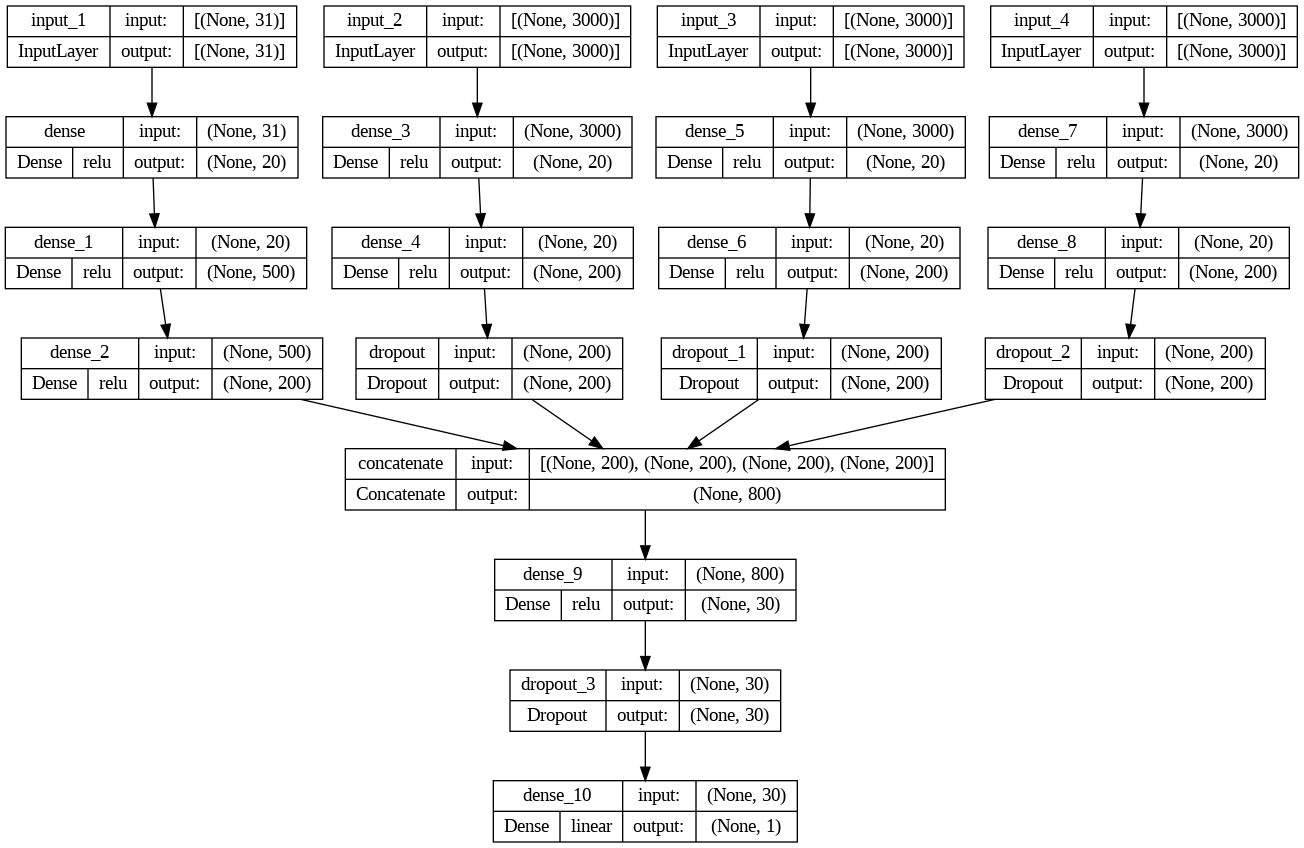

In [ ]:
utils.plot_model(model, dpi=96, show_shapes=True, show_layer_activations=True)

Мы видим, что модель состоит из четырех входов, где слои и гиперпараметры подобраны случайным образом и не оптимизированы, однако, логика в построении архитектуры все же соблюдалась.

А именно:
* добавленны слои регуляризации `Dropout`, на выходе из веток с текстовыми данными
* выходы из каждой ветки перед операцией объединения веток (операция `concatenate` в Keras) имеют одинаковую размерность
* выходной слой состоит из одного регрессирующего нейрона с линейной функцией активации, перед которым используется слой регуляризации `Dropout`.

**Обучим модель**

Обратите внимание, что `model.fit()` мы передаем в списке весь наш массив обучающих данных, в том же порядке, что мы определили в моделе `Model((input1, input2, input3, input4), x)`. В качестве функции потерь мы используем среднюю квадратичную ошибку (`mse`). В качестве метрики анализируем cреднюю абсолютную ошибку (`mae`), которая должна снижаться в процессе обучения.

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

history = model.fit([x_train[:8000], x_train_education[:8000], x_train_works[:8000], x_train_position[:8000]],
                           y_train_scaled[:8000],
                           batch_size=256,
                           epochs=100,
                           validation_data=([x_train[8000:], x_train_education[8000:], x_train_works[8000:], x_train_position[8000:]], y_train_scaled[8000:]),
                           verbose=1)

Epoch 1/100
32/32 [==============================] - 22s 465ms/step - loss: 1.0502 - mae: 0.5187 - val_loss: 0.9820 - val_mae: 0.5228
Epoch 2/100
32/32 [==============================] - 2s 68ms/step - loss: 1.0419 - mae: 0.5124 - val_loss: 0.9741 - val_mae: 0.5170
Epoch 3/100
32/32 [==============================] - 2s 68ms/step - loss: 1.0345 - mae: 0.5061 - val_loss: 0.9674 - val_mae: 0.5122
Epoch 4/100
32/32 [==============================] - 3s 92ms/step - loss: 1.0268 - mae: 0.5022 - val_loss: 0.9613 - val_mae: 0.5082
Epoch 5/100
32/32 [==============================] - 6s 180ms/step - loss: 1.0231 - mae: 0.4999 - val_loss: 0.9559 - val_mae: 0.5054
Epoch 6/100
32/32 [==============================] - 2s 68ms/step - loss: 1.0150 - mae: 0.4949 - val_loss: 0.9510 - val_mae: 0.5012
Epoch 7/100
32/32 [==============================] - 2s 69ms/step - loss: 1.0095 - mae: 0.4904 - val_loss: 0.9460 - val_mae: 0.4975
Epoch 8/100
32/32 [==============================] - 3s 92ms/step - loss:

**Визуализируем процесс обучения**

Средняя абсолютная ошибка показывает нам на сколько в абсолютных величинах ошибается наша модель. Если бы мы не нормализовали данные, то каждая точка на графике соответствовала бы среднему отклонению в тысячах рублей предсказанного значения от реального.

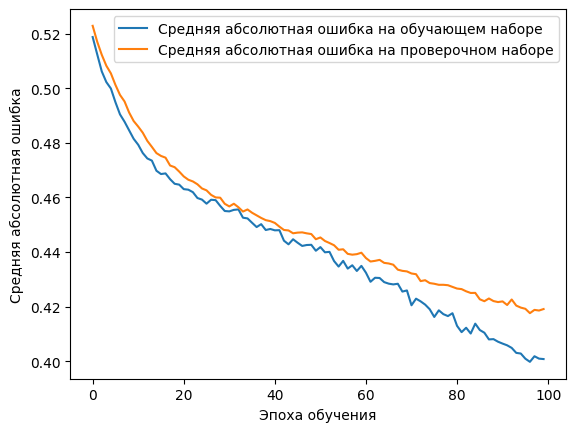

In [ ]:
plt.plot(history.history['mae'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

По графику обучения, мы видим, что ошибка продолжает снижаться, переобучения не наблюдается, можно и дальше продолжать обучение.

Выведем 100 точек из проверочной выборки и отобразим их на диагональной линии ожидаемых значений. Также выведем среднюю абсолютную ошибку.

4/4 [==============================] - 0s 12ms/step
Средняя абсолютная ошибка: 10.798620958099363 

Реальное значение:  20.00  Предсказанное значение:  28.80  Разница:   8.80
Реальное значение:  20.00  Предсказанное значение:  28.60  Разница:   8.60
Реальное значение:  40.00  Предсказанное значение:  35.10  Разница:   4.90
Реальное значение:   6.00  Предсказанное значение:  16.09  Разница:  10.09
Реальное значение:  15.28  Предсказанное значение:  24.92  Разница:   9.65
Реальное значение: 150.00  Предсказанное значение:  54.19  Разница:  95.81
Реальное значение:  25.00  Предсказанное значение:  27.50  Разница:   2.50
Реальное значение:  80.00  Предсказанное значение:  41.11  Разница:  38.89
Реальное значение:  30.00  Предсказанное значение:  34.62  Разница:   4.62
Реальное значение:  30.00  Предсказанное значение:  25.76  Разница:   4.24


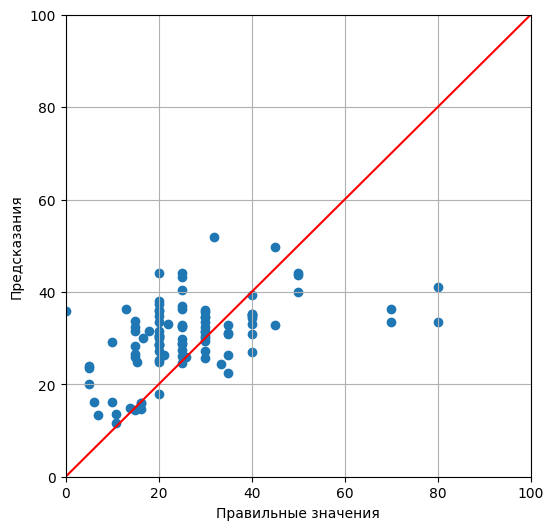

In [ ]:

pred = model.predict([x_train[8000:8100], x_train_education[8000:8100], x_train_works[8000:8100], x_train_position[8000:8100]])

pred = y_scaler.inverse_transform(pred)    # Обратная нормированию процедура

print('Средняя абсолютная ошибка:', mean_absolute_error(pred, y_train[8000:8100]), '\n') # расчет средней абсолютной ошибки

for i in range(10):
    print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(y_train[8000:8100][i, 0],
                                                                                                pred[i, 0],
                                                                                                abs(y_train[8000:8100][i, 0] - pred[i, 0])))
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_train[8000:8100], pred)          # Отрисовка точечного графика
ax.set_xlim(0, 100)                           # Ограничение оси по x
ax.set_ylim(0, 100)                           # Ограничение оси по x
ax.plot(plt.xlim(), plt.ylim(), 'r')          # Отрисовка диагональной линии
plt.xlabel('Правильные значения')
plt.ylabel('Предсказания')
plt.grid()
plt.show()

Значение средней абсолютной ошибки в 10.7, говорит о том, что наша модель в среднем ошибается на 10700 рублей при предсказании ожидаемой зарплаты от указанной в резюме.

In [ ]:
# Освобождение памяти от промежуточных данных
del history, model, pred

## Упрощенная модель

Рассмотрим еще одну упрощенную модель. Для упрощения модели сделаем следующее допущение: вся информация об опыте работы соискателя содержится в его общем опыте работы `experience` и должности, на которую претендует соискатель. Т.е., выставляя свое резюме, соискатель будет ориентироваться на цену по рынку, а не на свои прежние места работы и знания. Надо понимать, что резюме - это всего лишь пожелания соискателя, а не его реальная зарплата!

При таком допущении нам достаточно использовать 2 ветки НС вместо 4-х. Первая ветка - это все наши числовые данные, а вторая ветка - текстовое значение должности.

**Архитектура упрощенной модели**

In [ ]:
input1 = Input((x_train.shape[1],))
input2 = Input((x_train_position.shape[1],))

# Первый вход для числовых данных
x1 = input1
x1 = Dense(20, activation="relu")(x1)
x1 = Dense(500, activation="relu")(x1)
x1 = Dense(200, activation="relu")(x1)

# Второй вход для данных о желаемой должности
x2 = input2
x2 = Dense(20, activation="relu")(x2)
x2 = Dense(200, activation="relu")(x2)
x2 = Dropout(0.3)(x2)


# Объединение четырех веток
x = concatenate([x1, x2])

# Промежуточный слой
x = Dense(30, activation='relu')(x)
x = Dropout(0.5)(x)

# Финальный регрессирующий нейрон
x = Dense(1, activation='linear')(x)

# В Model передаются входы и выход
model = Model((input1, input2), x)

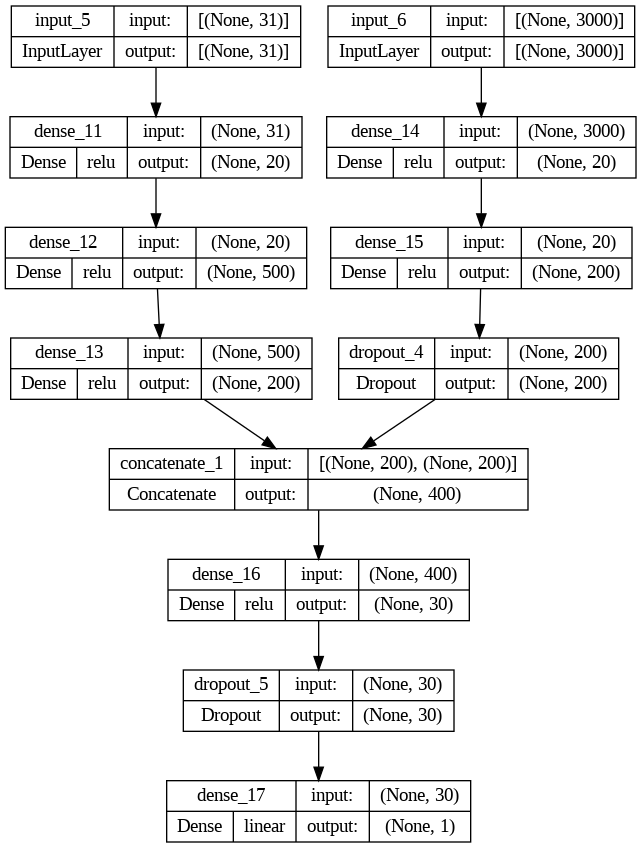

In [ ]:
utils.plot_model(model, dpi=96, show_shapes=True, show_layer_activations=True)

**Обучим модель**

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

history = model.fit([x_train[:8000], x_train_position[:8000]],
                           y_train_scaled[:8000],
                           batch_size=256,
                           epochs=100,
                           validation_data=([x_train[8000:], x_train_position[8000:]], y_train_scaled[8000:]),
                           verbose=1)

Epoch 1/100
32/32 [==============================] - 8s 203ms/step - loss: 1.0531 - mae: 0.5202 - val_loss: 0.9890 - val_mae: 0.5249
Epoch 2/100
32/32 [==============================] - 2s 50ms/step - loss: 1.0523 - mae: 0.5159 - val_loss: 0.9841 - val_mae: 0.5204
Epoch 3/100
32/32 [==============================] - 3s 90ms/step - loss: 1.0431 - mae: 0.5116 - val_loss: 0.9799 - val_mae: 0.5171
Epoch 4/100
32/32 [==============================] - 2s 59ms/step - loss: 1.0413 - mae: 0.5089 - val_loss: 0.9762 - val_mae: 0.5149
Epoch 5/100
32/32 [==============================] - 1s 44ms/step - loss: 1.0386 - mae: 0.5079 - val_loss: 0.9727 - val_mae: 0.5125
Epoch 6/100
32/32 [==============================] - 1s 39ms/step - loss: 1.0322 - mae: 0.5026 - val_loss: 0.9691 - val_mae: 0.5098
Epoch 7/100
32/32 [==============================] - 1s 38ms/step - loss: 1.0295 - mae: 0.5021 - val_loss: 0.9659 - val_mae: 0.5077
Epoch 8/100
32/32 [==============================] - 1s 46ms/step - loss: 1

**Визуализируем результат обучения**

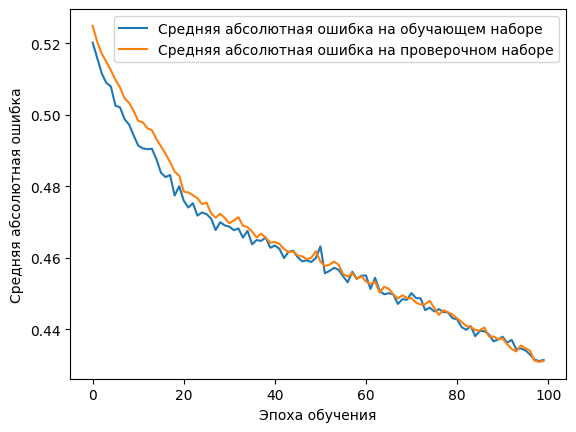

In [ ]:
plt.plot(history.history['mae'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

4/4 [==============================] - 0s 3ms/step
Средняя абсолютная ошибка: 10.431022831192017 

Реальное значение:  20.00  Предсказанное значение:  27.95  Разница:   7.95
Реальное значение:  20.00  Предсказанное значение:  26.25  Разница:   6.25
Реальное значение:  40.00  Предсказанное значение:  45.96  Разница:   5.96
Реальное значение:   6.00  Предсказанное значение:  16.04  Разница:  10.04
Реальное значение:  15.28  Предсказанное значение:  22.77  Разница:   7.50
Реальное значение: 150.00  Предсказанное значение:  42.10  Разница: 107.90
Реальное значение:  25.00  Предсказанное значение:  29.66  Разница:   4.66
Реальное значение:  80.00  Предсказанное значение:  39.72  Разница:  40.28
Реальное значение:  30.00  Предсказанное значение:  31.23  Разница:   1.23
Реальное значение:  30.00  Предсказанное значение:  23.15  Разница:   6.85


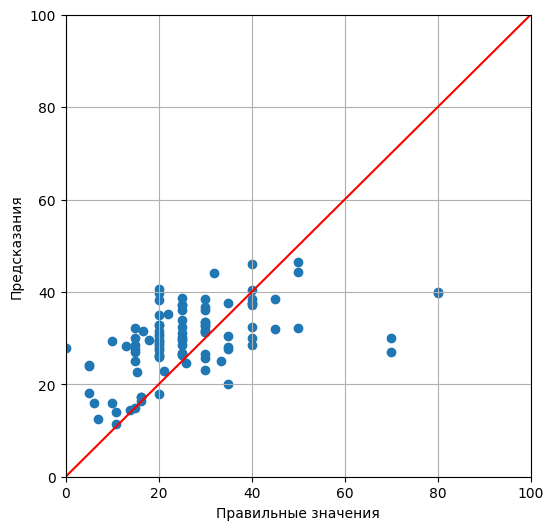

In [ ]:
pred = model.predict([x_train[8000:8100], x_train_position[8000:8100]])  # Предсказание на новых данных (контрольный образец)

pred = y_scaler.inverse_transform(pred)    # Обратная нормированию процедура


print('Средняя абсолютная ошибка:', mean_absolute_error(pred, y_train[8000:8100]), '\n') # расчет средней абсолютной ошибки

for i in range(10):
    print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(y_train[8000:8100][i, 0],
                                                                                                pred[i, 0],
                                                                                                abs(y_train[8000:8100][i, 0] - pred[i, 0])))
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_train[8000:8100], pred)          # Отрисовка точечного графика
ax.set_xlim(0, 100)                           # Ограничение оси по x
ax.set_ylim(0, 100)                           # Ограничение оси по x
ax.plot(plt.xlim(), plt.ylim(), 'r')          # Отрисовка диагональной линии
plt.xlabel('Правильные значения')
plt.ylabel('Предсказания')
plt.grid()
plt.show()

Значение средней абсолютной ошибки в 10.4 для упрощенной модели, говорит о том, что наша модель в среднем ошибается на 10400, что немного лучше прежнего результата. Может показаться, что упрощенная модель лучше? Но это не совсем так. Более тяжелая модель с 4 ветками будет дольше обучаться. Тем более мы видим, что нет переобучения, что даже на 100 эпохах обе модели продолжают обучаться и дальше.  

На этом наше знакомство с регрессионными моделями подошло к концу и пора приступить к выполнению [домашней работы](https://colab.research.google.com/drive/1iPTkGZ_AEUpl5l6DR__J021gHR61RRfQ).